# A detailed analysis of AbiWord network

http://abiword.org/

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms.cluster import average_clustering
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from networkx.algorithms.cluster import transitivity
from networkx.algorithms.distance_measures import diameter
from networkx.algorithms import centrality
from networkx.algorithms.link_analysis import pagerank_alg
from networkx.algorithms.assortativity import degree_assortativity_coefficient as dac
from networkx.algorithms.bipartite.spectral import spectral_bipartivity as sb
from networkx.generators import random_graphs as rg
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%config InlineBackend.figure_format='retina'

In [2]:
def to_graph():
    df=pd.read_csv('Abi.csv')
    df.columns=['n1','n2','c']
    conn={}
    for val in df['n2'].unique():
        conn[val]=df['n1'][df['n2']==val].to_list()
    graph=nx.Graph(conn)
    return graph

In [3]:
g=to_graph()

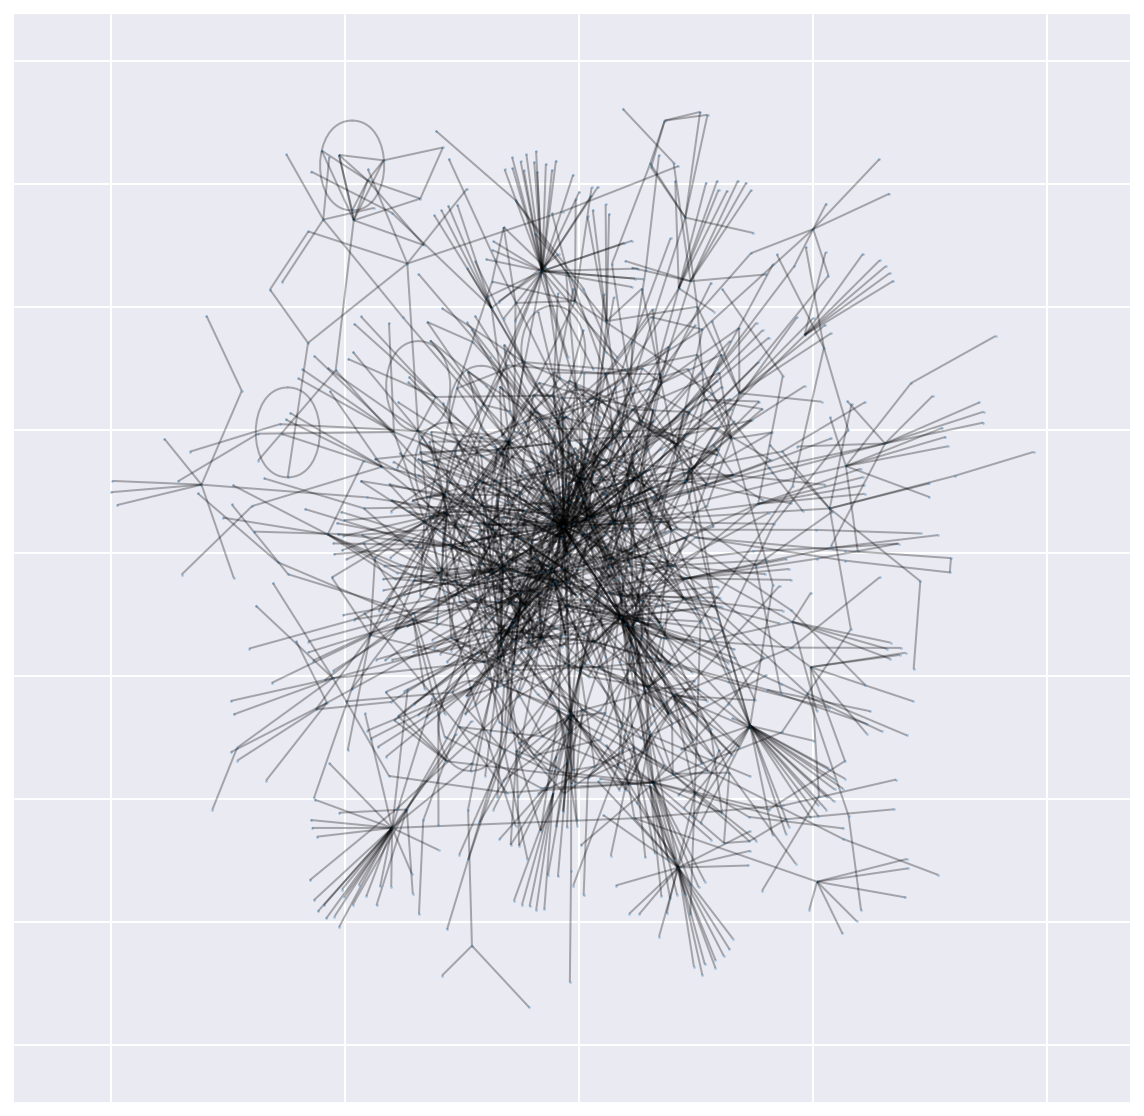

In [4]:
pos = nx.spring_layout(g, k=0.1)
fig, ax=plt.subplots(figsize=(10,10))
nx.draw_networkx(g, pos=pos, node_size=1, alpha=0.3, with_labels=False)

***

## Network structural analysis

In [5]:
def get_a_to_d(g):
    a1,a2,a3=nx.number_of_nodes(g),nx.number_of_edges(g),nx.density(g)
    b=average_clustering(g)
    c=transitivity(g)
    d1,d2=average_shortest_path_length(g,method='dijkstra'), diameter(g)
    return a1,a2,a3,b,c,d1,d2

In [6]:
ex1=get_a_to_d(g)
ex1

(1035,
 1736,
 0.003244283725319803,
 0.058250886330044,
 0.03873820754716981,
 5.082043375475383,
 12)

- a) Number of nodes, links, network density.
- b) Average clustering coefficient of the nodes (Watts-Strogatz clustering coefficient).
- c) Global clustering coefficient (Newman transitivity).
- d) Average path length and diameter of the network.

In [7]:
strVals=['Number of nodes', 'links', 'network density','Watts-Strogatz clustering coefficient',\
        'Newman transitivity','Average path length', 'diameter of the network']
ex1res={}
for val,i in zip(strVals,range(len(strVals))):
    ex1res[val]=ex1[i]

#### Summarized results for part a-d

In [8]:
df_ex1_atod=pd.DataFrame(ex1res.items(),columns=['structural measure','Real'])
df_ex1_atod

,structural measure,Real
0,Number of nodes,1035.000000
1,links,1736.000000
2,network density,0.003244
3,Watts-Strogatz clustering coefficient,0.058251
4,Newman transitivity,0.038738
5,Average path length,5.082043
6,diameter of the network,12.000000


In [9]:
dfex1 = df_ex1_atod.loc[2:]
dfex1

,structural measure,Real
2,network density,0.003244
3,Watts-Strogatz clustering coefficient,0.058251
4,Newman transitivity,0.038738
5,Average path length,5.082043
6,diameter of the network,12.000000


#### Degree distribution of the network

In [10]:
def degDist(g):
    degDict=g.degree()
    degdist=[]
    for key in range(len(degDict)):
        degdist.append(degDict[key+1])
    return degdist

In [11]:
from fitter import Fitter, get_common_distributions, get_distributions
import warnings
warnings.filterwarnings('ignore')

In [12]:
f = Fitter(degDist(g),distributions= get_distributions())
f.fit();

\begin{tabular}{lr}
\toprule
{} &  sumsquare\_error \\
\midrule
gilbrat       &         0.001619 \\
pearson3      &         0.001780 \\
weibull\_min   &         0.004106 \\
wald          &         0.006122 \\
recipinvgauss &         0.007440 \\
\bottomrule
\end{tabular}



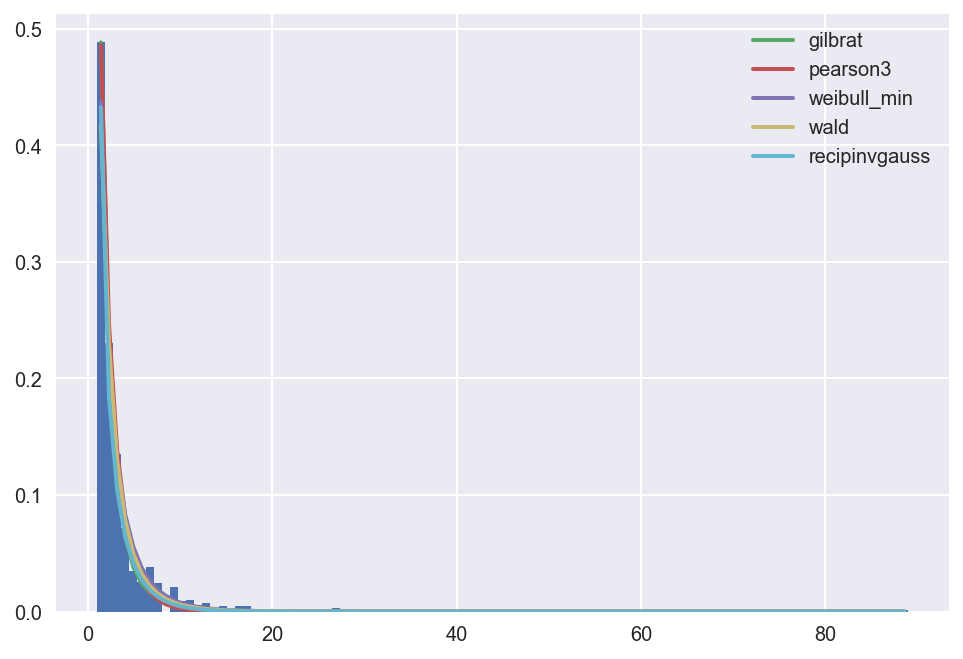

In [13]:
print(f.summary()['sumsquare_error'].to_latex())

Text(0, 0.5, 'PDF')

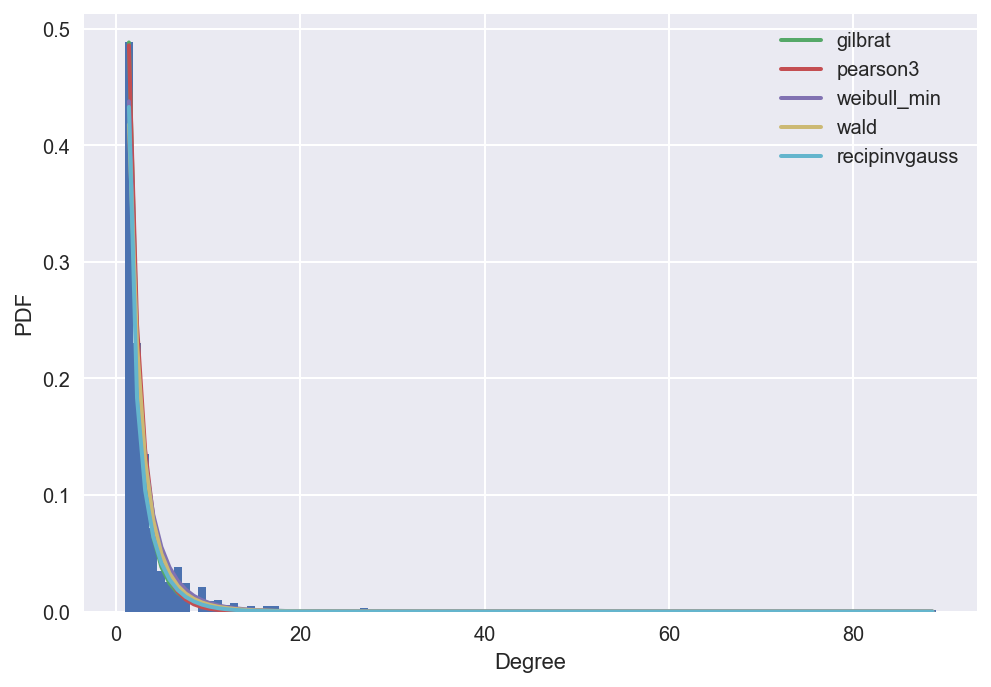

In [15]:
f.summary()
plt.xlabel('Degree')
plt.ylabel('PDF')

In [16]:
f.get_best(method = 'sumsquare_error')

{'gilbrat': {'loc': 0.6859076632727243, 'scale': 1.1252595765003548}}

In [17]:
f.fitted_param['gilbrat']

(0.6859076632727243, 1.1252595765003548)

In [18]:
from scipy import stats as st

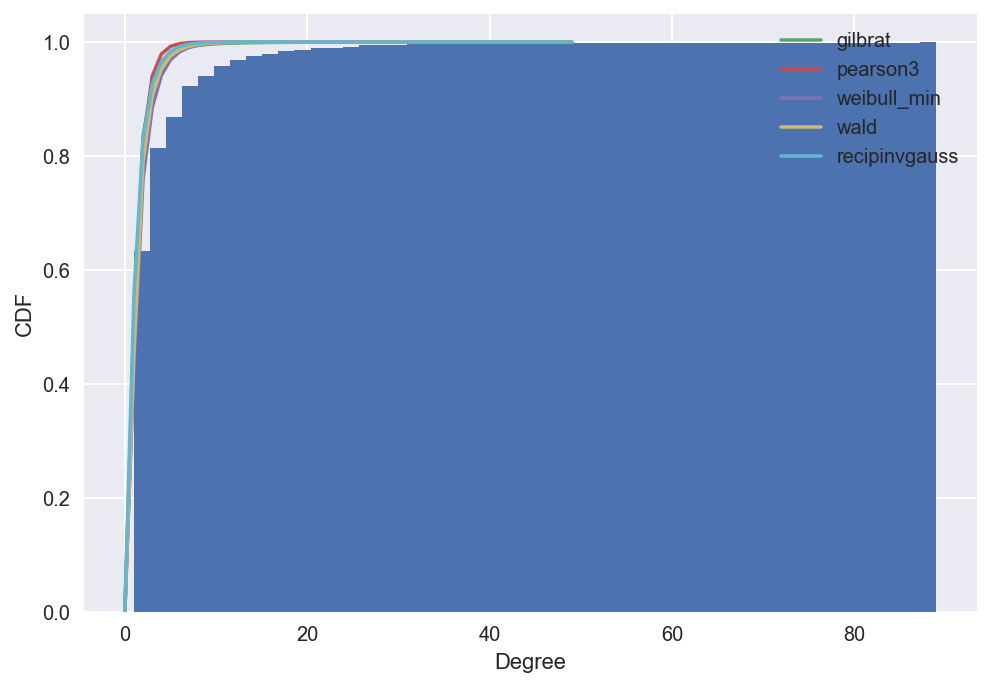

In [20]:
x=np.linspace(0,90)
plt.hist(degDist(g),bins=50,density=True,cumulative=True)
plt.plot(st.gilbrat.cdf(x,*f.fitted_param['gilbrat']),label = 'gilbrat')
plt.plot(st.pearson3.cdf(x,*f.fitted_param['pearson3']),label = 'pearson3')
plt.plot(st.weibull_min.cdf(x,*f.fitted_param['weibull_min']),label = 'weibull_min')
plt.plot(st.wald.cdf(x,*f.fitted_param['wald']),label = 'wald')
plt.plot(st.recipinvgauss.cdf(x,*f.fitted_param['recipinvgauss']),label = 'recipinvgauss')
plt.ylabel('CDF')
plt.xlabel('Degree')
plt.legend()

#### Top most central nodes according to various centralities.

In [21]:
# Function to sort dictionary by values and returns top 25 candidates
def get25(x):
    temp={k: v for k, v in sorted(x.items(),reverse=True, key=lambda item: item[1])}
    return dict(list(temp.items())[0: 25])

In [22]:
def centralities(g):
    degCen=centrality.degree_centrality(g)
    topdegCen=get25(degCen)
    return topdegCen,

In [23]:
degCen=centrality.degree_centrality(g)
topdegCen=get25(degCen)
dfDeg=pd.DataFrame(topdegCen.items(),columns=['Node','Degree centrality'])

In [24]:
closeCen=centrality.closeness_centrality(g)
topcloseCen=get25(closeCen)
dfClose=pd.DataFrame(topcloseCen.items(),columns=['Node','Closeness centrality'])

In [25]:
betCen=centrality.betweenness_centrality(g)
topbetCen=get25(betCen)
dfBet=pd.DataFrame(topbetCen.items(),columns=['Node','Betweenness centrality'])

In [26]:
evecCen=centrality.eigenvector_centrality(g)
topevecCen=get25(evecCen)
dfEvev=pd.DataFrame(topevecCen.items(),columns=['Node','Eigenvector centrality'])

In [27]:
katzCen=centrality.katz_centrality_numpy(g)
topkatzCen=get25(katzCen)
dfKatz=pd.DataFrame(topkatzCen.items(),columns=['Node','Katz index centrality'])

In [28]:
pageCen=pagerank_alg.pagerank(g)
toppageCen=get25(pageCen)
dfPage=pd.DataFrame(toppageCen.items(),columns=['Node','PageRank centrality'])

In [29]:
subCen=centrality.subgraph_centrality(g)
topsubCen=get25(subCen)
dfSub=pd.DataFrame(topsubCen.items(),columns=['Node','Subgraph centrality'])

#### Summarized results for part e

In [30]:
dfe =pd.concat([dfDeg,dfClose,dfBet,dfEvev,dfKatz,dfPage,dfSub],axis=1)
dfe.round(3)

,Node,Degree centrality,Node,Closeness centrality,Node,Betweenness centrality,Node,Eigenvector centrality,Node,Katz index centrality,Node,PageRank centrality,Node,Subgraph centrality
0,630,0.086,630,0.334,630,0.334,630,0.510,962,0.086,630,0.018,630,43640.722
1,725,0.045,725,0.323,725,0.264,725,0.256,413,0.057,962,0.014,725,11359.477
2,539,0.041,100,0.310,711,0.212,539,0.224,301,0.053,413,0.011,539,8877.001
3,962,0.034,98,0.309,539,0.114,644,0.210,473,0.052,725,0.010,644,7547.621
4,711,0.031,644,0.308,595,0.103,378,0.147,393,0.039,473,0.010,378,3675.203
5,644,0.029,96,0.297,392,0.103,290,0.138,831,0.035,351,0.009,290,3287.974
6,351,0.026,539,0.294,644,0.073,100,0.130,832,0.035,711,0.009,100,2878.502
7,394,0.026,101,0.290,621,0.070,98,0.126,707,0.030,539,0.008,98,2702.214
8,621,0.026,704,0.289,394,0.068,380,0.118,520,0.029,621,0.006,394,2404.412
9,413,0.023,290,0.288,962,0.061,394,0.116,864,0.028,644,0.006,380,2399.872


#### Degree assortativity

In [31]:
dac(g)

-0.08350592775831821

#### Bipartivity index

In [32]:
sb(g)

0.5648266257046257

***

#### Random realisations

In [47]:
def a_to_d(g):
    a1,a2,a3=nx.number_of_nodes(g),nx.number_of_edges(g),nx.density(g)
    b=average_clustering(g)
    c=transitivity(g)
    avg=[]
    for C in (g.subgraph(c).copy() for c in nx.connected_components(g)):
        avg.append(np.mean(nx.average_shortest_path_length(C)))
    dia=max([max(j.values()) for (i,j) in nx.shortest_path_length(g)])
    d1,d2=avg[0], dia
    return [a1,a2,a3,b,c,d1,d2]

### ER realizations

In [48]:
ERg=[]
for i in range(10):
    #oneG=rg.gnm_random_graph(1035, 1736)
    oneG=rg.erdos_renyi_graph(1035, 0.00314)
    ERg.append(oneG)

In [49]:
allER=[]
for i in range(len(ERg)):
    allER.append(a_to_d(ERg[i]))

In [50]:
df_ex1_atod['ER mean']=np.mean(allER,axis=0)
df_ex1_atod['ER std']=np.std(allER,axis=0)
df_ex1_atod.loc[2:]

,structural measure,Real,ER mean,ER std
2,network density,0.003244,0.003140,0.000052
3,Watts-Strogatz clustering coefficient,0.058251,0.003001,0.001164
4,Newman transitivity,0.038738,0.003918,0.000978
5,Average path length,5.082043,5.920713,0.100337
6,diameter of the network,12.000000,13.000000,0.632456


In [51]:
def degDist1(g):
    degDict=g.degree()
    degdist=[]
    for key in range(len(degDict)):
        degdist.append(degDict[key])
    return degdist

In [52]:
allERdeg=[]
for gr in range(len(ERg)):
    allERdeg.append(degDist1(ERg[gr]))
    meanER=np.mean(allERdeg,axis=0)
    stdER=np.std(allERdeg,axis=0)

Text(0, 0.5, 'PDF')

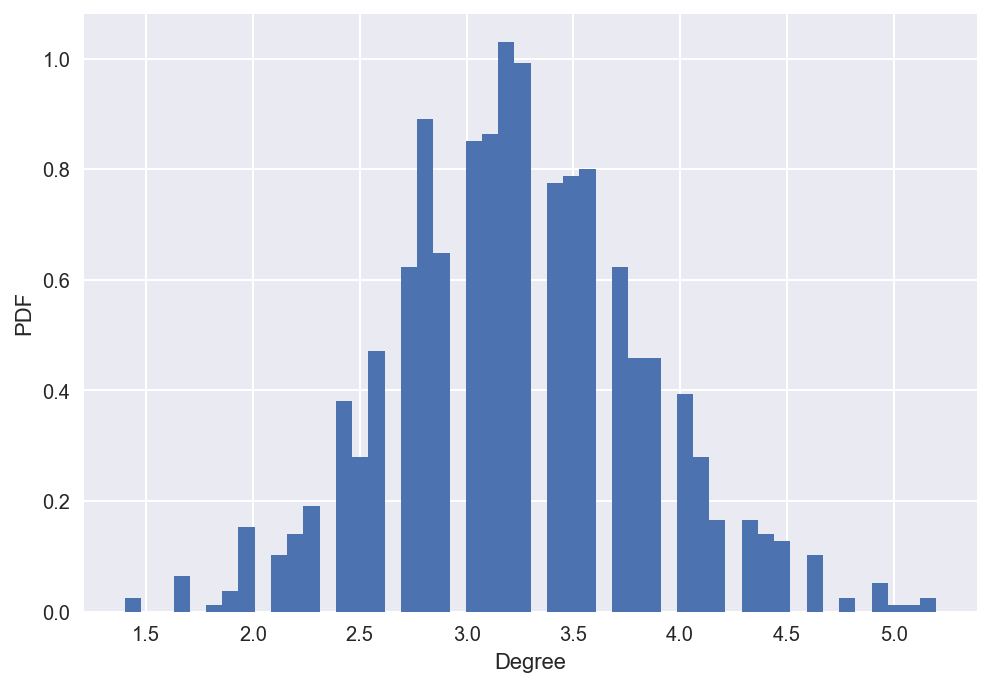

In [63]:
plt.hist(meanER,bins=50,density=True)
plt.xlabel('Degree')
plt.ylabel('PDF')

Text(0, 0.5, 'CDF')

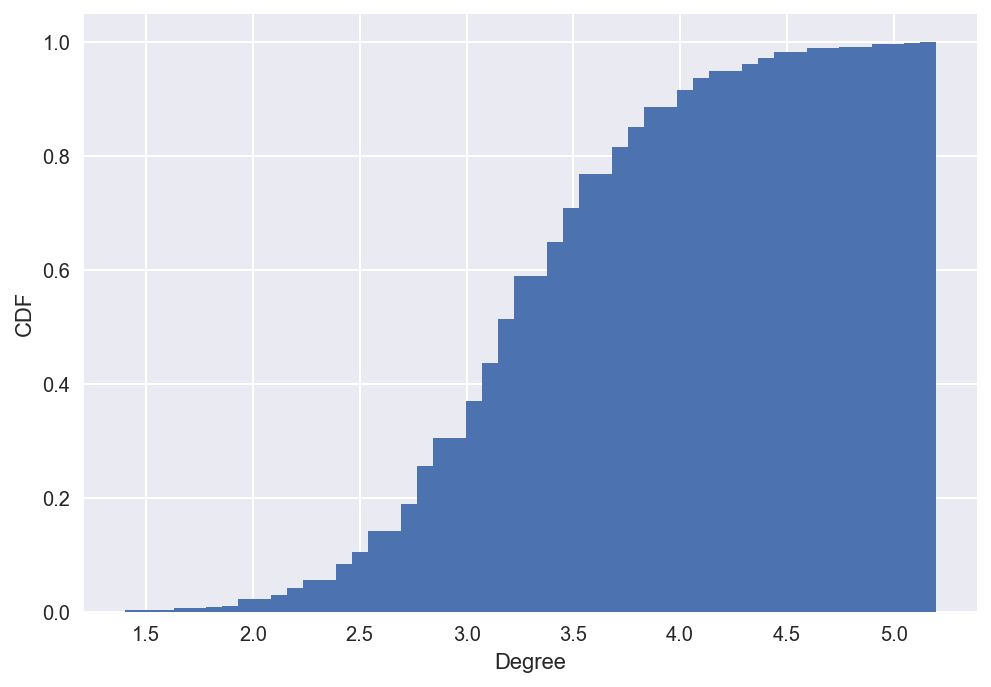

In [64]:
#plt.hist(degDist(g),bins=50,density=True,label='Real',cumulative=True)
plt.hist(meanER,bins=50,density=True,cumulative=True)
plt.xlabel('Degree')
plt.ylabel('CDF')

In [55]:
np.mean([dac(ERg[i]) for i in range(len(ERg))])

0.007141132893281057

In [89]:
np.std([dac(ERg[i]) for i in range(len(ERg))])

0.023703287916627173

In [56]:
np.mean([sb(ERg[i]) for i in range(len(ERg))])

0.9939396437514757

In [90]:
np.std([sb(ERg[i]) for i in range(len(ERg))])

0.0012360467522364513

### BA realizations

In [57]:
BAg=[]
for i in range(10):
    oneGr=rg.barabasi_albert_graph(1035, 2)
    BAg.append(oneGr)

In [58]:
allBA=[]
for i in range(len(BAg)):
    allBA.append(a_to_d(BAg[i]))

In [59]:
df_ex1_atod['BA mean']=np.mean(allBA,axis=0)
df_ex1_atod['BA std']=np.std(allBA,axis=0)
df_ex1_atod[2:]

,structural measure,Real,ER mean,ER std,BA mean,BA std
2,network density,0.003244,0.003140,0.000052,0.003861,0.000000
3,Watts-Strogatz clustering coefficient,0.058251,0.003001,0.001164,0.024117,0.005625
4,Newman transitivity,0.038738,0.003918,0.000978,0.009557,0.001614
5,Average path length,5.082043,5.920713,0.100337,4.110433,0.047859
6,diameter of the network,12.000000,13.000000,0.632456,7.300000,0.458258


In [61]:
allBAdeg=[]
for gr in range(len(BAg)):
    allBAdeg.append(degDist1(BAg[gr]))
    meanBA=np.mean(allBAdeg,axis=0)
    stdBA=np.std(allBAdeg,axis=0)

Text(0, 0.5, 'PDF')

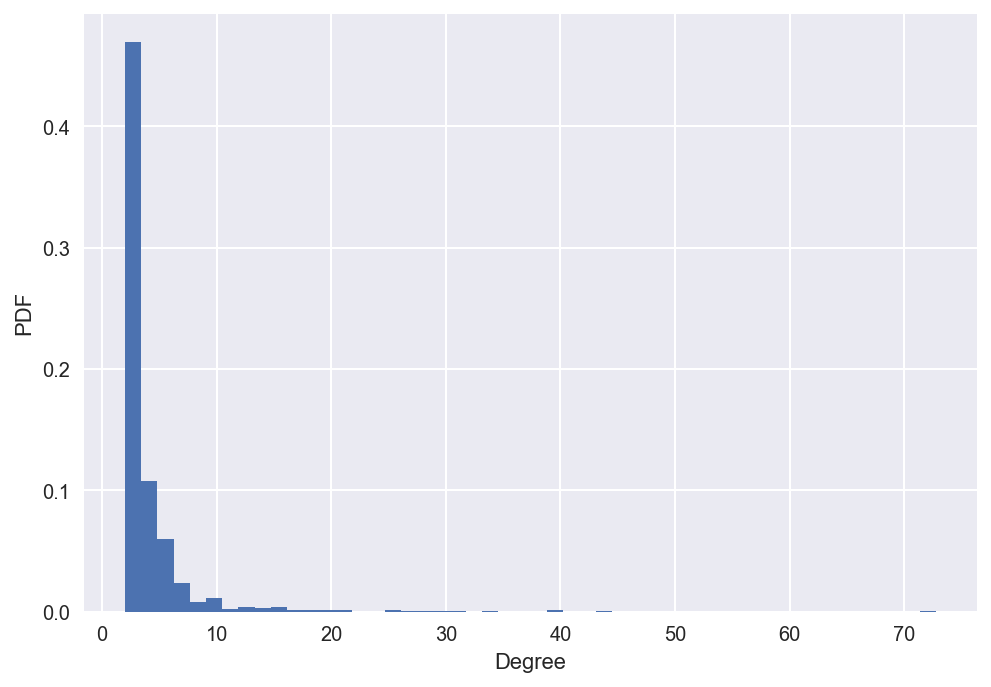

In [66]:
#plt.hist(degDist(g),bins=50,density=True,label='Real')
plt.hist(meanBA,bins=50,density=True)
plt.xlabel('Degree')
plt.ylabel('PDF')

In [67]:
fBA = Fitter(meanBA,distributions= get_distributions())
fBA.fit();

Text(0, 0.5, 'PDF')

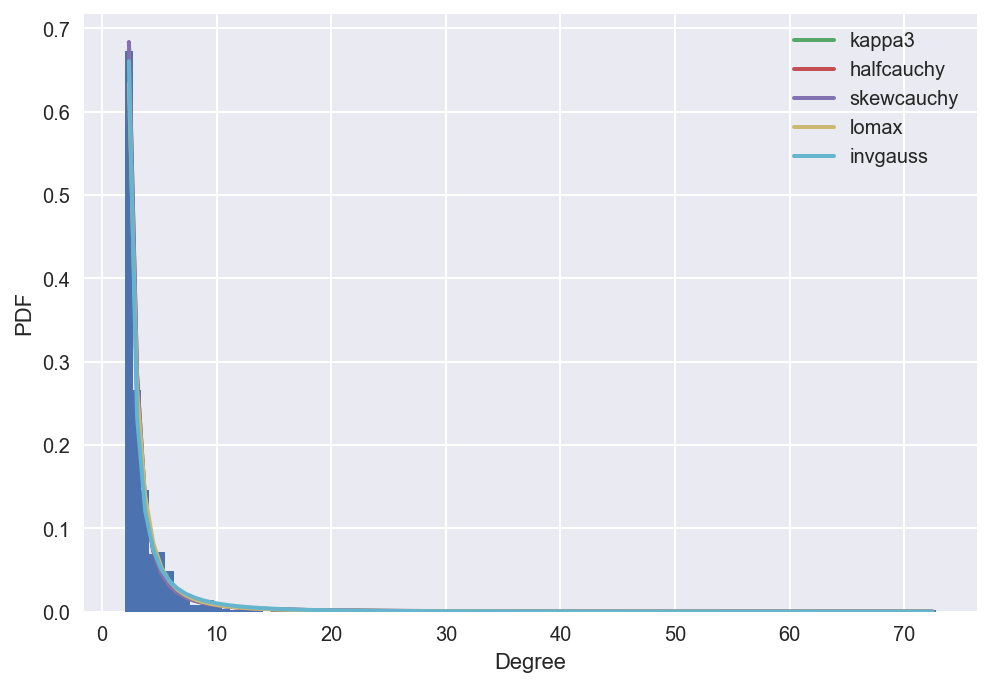

In [68]:
fBA.summary()
plt.xlabel('Degree')
plt.ylabel('PDF')

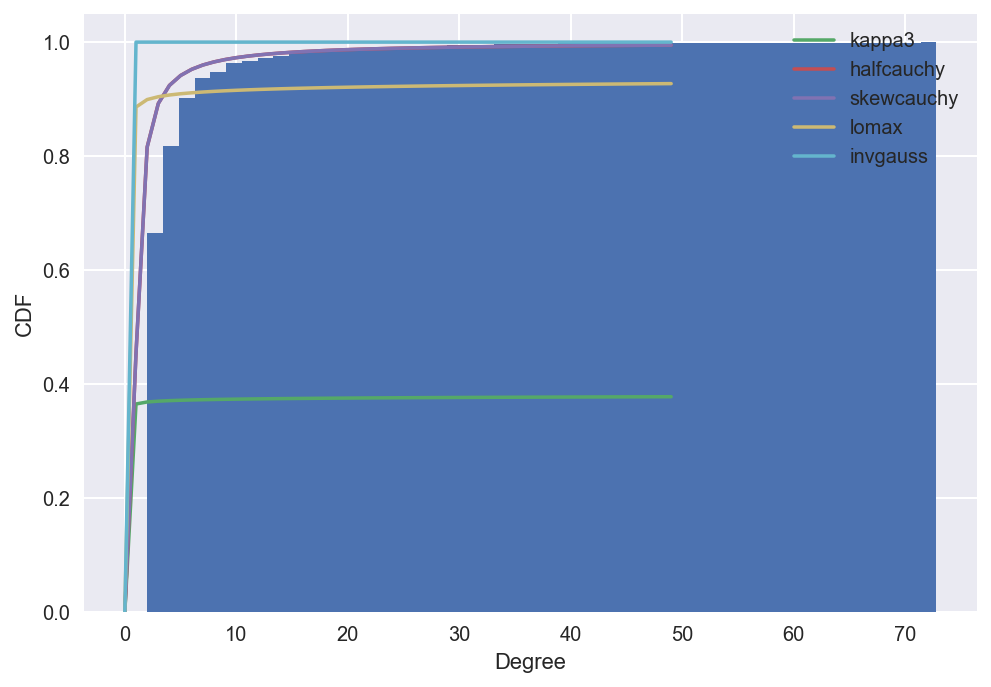

In [69]:
x=np.linspace(0,75)
plt.hist(meanBA,bins=50,density=True,cumulative=True)
plt.plot(st.kappa3.cdf(x,*f.fitted_param['kappa3']),label = 'kappa3')
plt.plot(st.halfcauchy.cdf(x,*f.fitted_param['halfcauchy']),label = 'halfcauchy')
plt.plot(st.skewcauchy.cdf(x,*f.fitted_param['skewcauchy']),label = 'skewcauchy')
plt.plot(st.lomax.cdf(x,*f.fitted_param['lomax']),label = 'lomax')
plt.plot(st.invgauss.cdf(x,*f.fitted_param['invgauss']),label = 'invgauss')
plt.ylabel('CDF')
plt.xlabel('Degree')
plt.legend()

In [70]:
np.mean([dac(BAg[i]) for i in range(len(BAg))])

-0.09499406803729409

In [91]:
np.std([dac(BAg[i]) for i in range(len(BAg))])

0.014976968284068956

In [71]:
np.mean([sb(BAg[i]) for i in range(len(BAg))])

0.7096713523757079

In [92]:
np.std([sb(BAg[i]) for i in range(len(BAg))])

0.04428583668066563

#### Communities

The network has 33 communities.


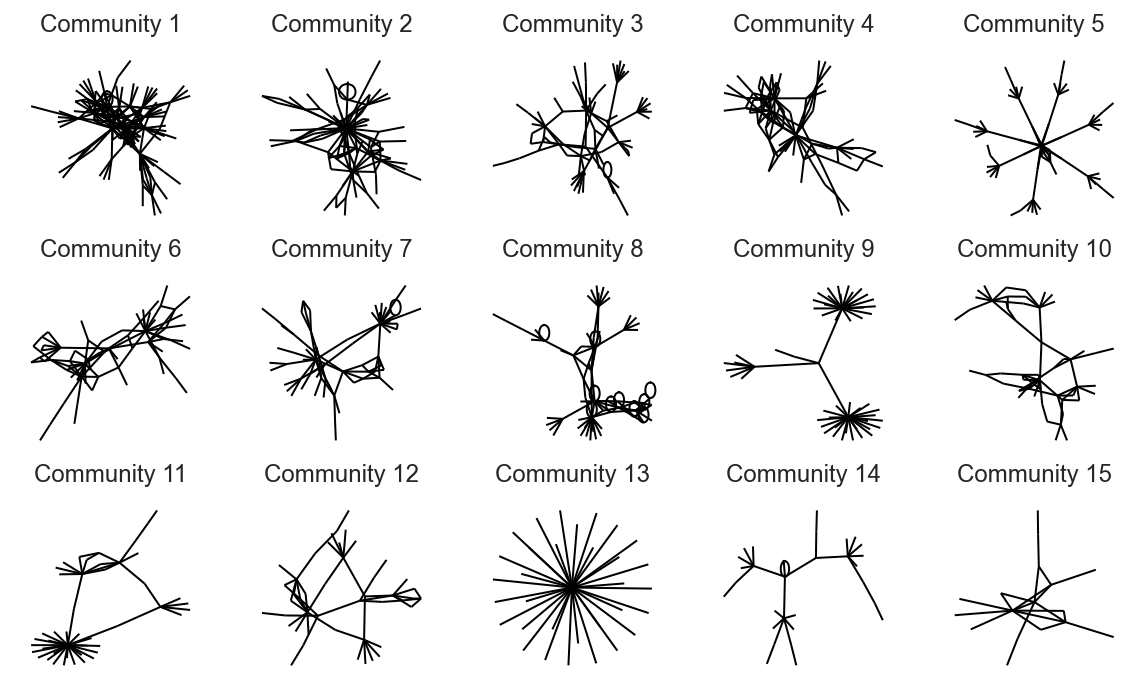

In [74]:
import networkx.algorithms.community as nx_comm


G = g

# Find the communities
communities = sorted(nx_comm.greedy_modularity_communities(G), key=len, reverse=True)

# Count the communities
print(f"The network has {len(communities)} communities.")

'''Add community to node attributes'''
for c, v_c in enumerate(communities):
    for v in v_c:
        # Add 1 to save 0 for external edges
        G.nodes[v]['community'] = c + 1

'''Find internal edges and add their community to their attributes'''
for v, w, in G.edges:
    if G.nodes[v]['community'] == G.nodes[w]['community']:
        # Internal edge, mark with community
        G.edges[v, w]['community'] = G.nodes[v]['community']
    else:
        # External edge, mark as 0
        G.edges[v, w]['community'] = 0



N_coms=len(communities)
edges_coms=[]#edge list for each community
coms_G=[nx.Graph() for _ in range(N_coms)] #community graphs
colors=['tab:blue','tab:orange','tab:green']
fig=plt.figure(figsize=(10,10))

for i in range(15):
    edges_coms.append([(u,v,d) for u,v,d in G.edges(data=True) if d['community'] == i+1])#identify edges of interest using the edge attribute
    coms_G[i].add_edges_from(edges_coms[i]) #add edges
    plt.subplot(5,5,i+1)#plot communities
    plt.title('Community '+str(i+1))
    pos = nx.spring_layout(coms_G[i])
    nx.draw(coms_G[i],pos=pos,with_labels=False,node_size=0) 

In [75]:
nx_comm.modularity(G,nx_comm.greedy_modularity_communities(G))

0.6915322580645161

***

## Dynamical analysis

In [83]:
g = to_graph()
nodes = g.number_of_nodes()
un_nodes = g.number_of_nodes()
nodes_list = [c for c in range(1,nodes + 1)]
prob = []
for x in range(un_nodes):
  num = np.random.randint(0, nodes)
  del_node = nodes_list.pop(num)
  g.remove_node(del_node)
  nodes = len(nodes_list)
  comps = nx.number_connected_components(g)
  giant_comp = sorted(nx.connected_components(g), key=len, reverse=True)
  if len(giant_comp) != 0:
    size_largest_component = len(giant_comp[0])
  else:
    size_largest_component = 0
  occ_p = nodes / un_nodes
  prob.append([comps, occ_p, size_largest_component])
prob = np.array(prob)

Text(0, 0.5, '\\# of connected components')

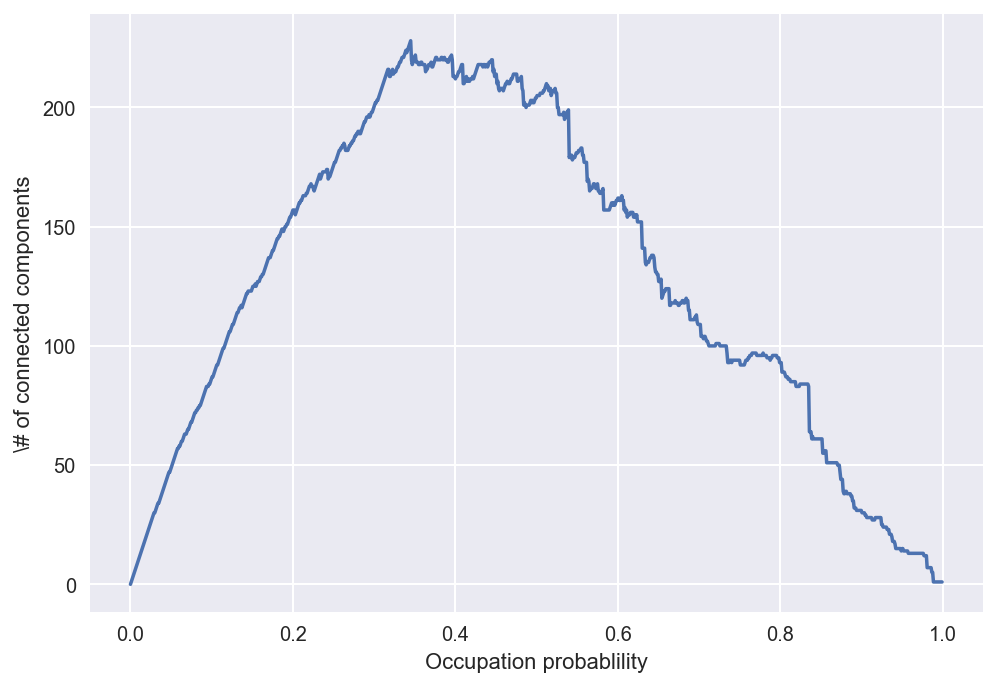

In [84]:
plt.plot(prob[:, 1], prob[:, 0])
plt.xlabel('Occupation probablility')
plt.ylabel('\# of connected components')

Text(0, 0.5, 'Largest component size')

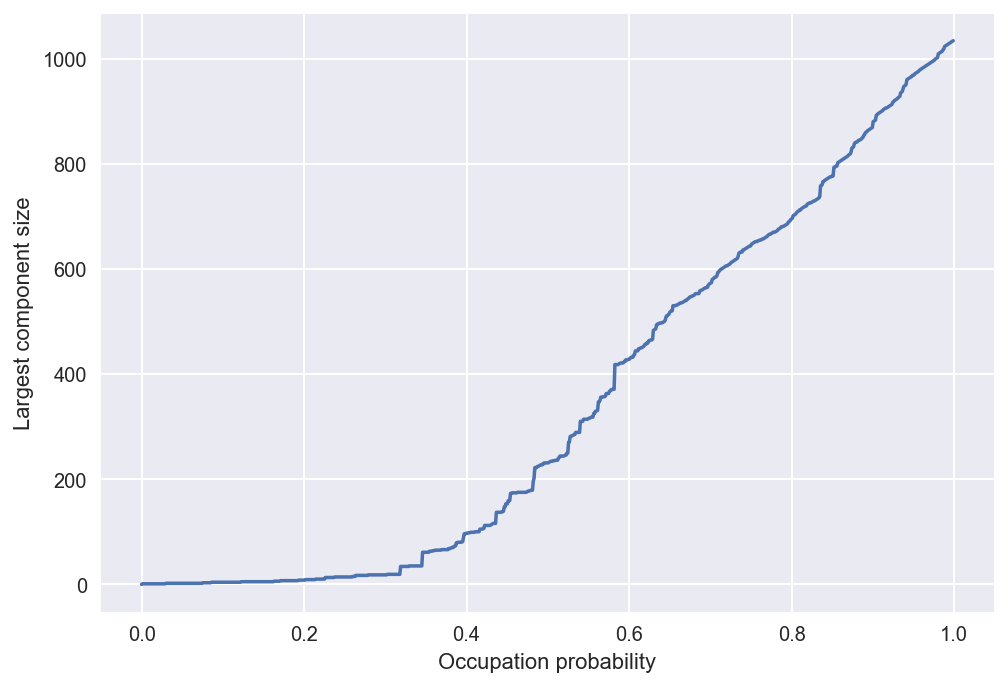

In [85]:
plt.plot(prob[:, 1], prob[:,2])
plt.xlabel('Occupation probability')
plt.ylabel('Largest component size')

In [123]:
g=to_graph()
nodes = g.number_of_nodes()
deg_dict = {n:d for n, d in g.degree()}
h_deg = sorted(deg_dict.items(), key=lambda x:x[1], reverse=True)
prob = []
for x in h_deg:
    g.remove_node(x[0])
    un_nodes = g.number_of_nodes()
    comps = nx.number_connected_components(g)
    gcomp = sorted(nx.connected_components(g), key=len, reverse=True)
    if len(gcomp)!=0:
        size_largest_component = len(gcomp[0])
    else:
        size_largest_component = 0
    occ_p = un_nodes/nodes
    prob.append([comps,occ_p,size_largest_component])

prob = np.array(prob)

Text(0, 0.5, '\\# of connected components')

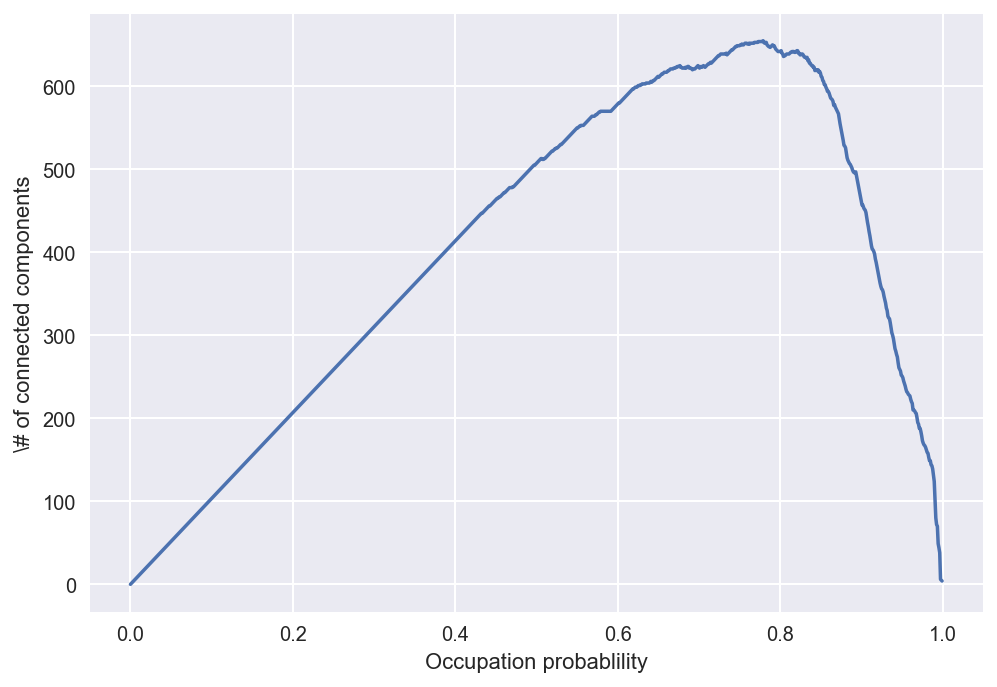

In [124]:
plt.plot(prob[:,1],prob[:,0])
plt.xlabel('Occupation probablility')
plt.ylabel('\# of connected components')

Text(0, 0.5, 'Largest component size')

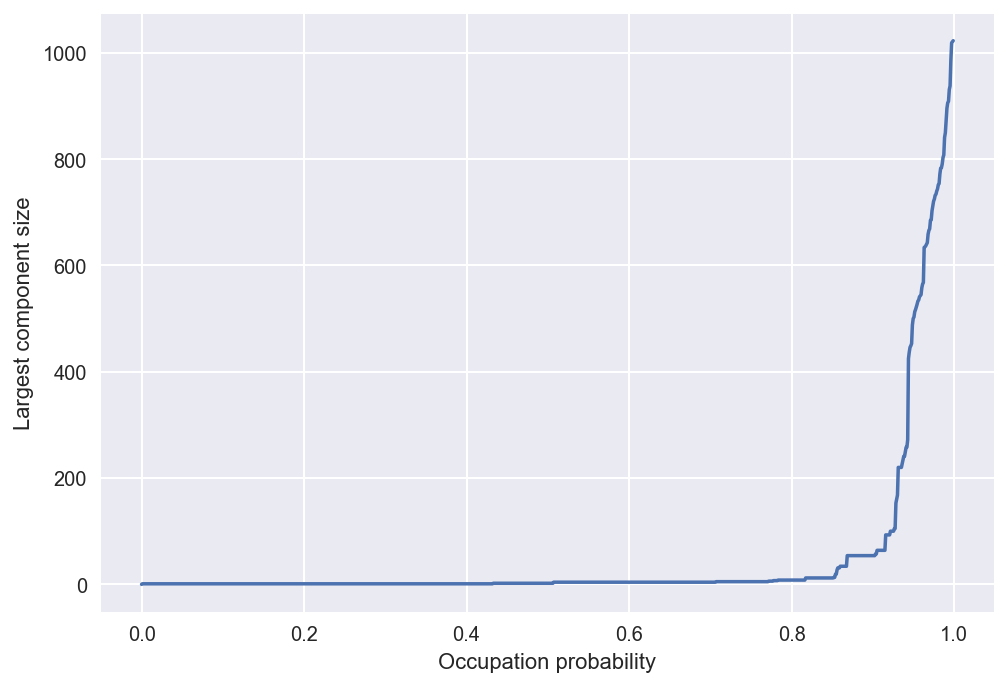

In [125]:
prob = np.array(prob)
plt.plot(prob[:,1],prob[:,2]) 
plt.xlabel('Occupation probability')
plt.ylabel('Largest component size')

***